In [ ]:
import os
os.environ["TORCHINDUCTOR_DISABLE"] = "1"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
from pathlib import Path

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

BASE_DIR = Path("/content/drive/Shareddrives/TissueMotionForecasting")
TRAIN_ROOT = BASE_DIR / "scared_data" / "train"
print("TRAIN_ROOT:", TRAIN_ROOT)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu
TRAIN_ROOT: /content/drive/Shareddrives/TissueMotionForecasting/scared_data/train


In [ ]:
CONTEXT_LEN = 3
HORIZON_SET = [3, 5, 7, 9]
H_MAX = max(HORIZON_SET)
DISP_SCALE = 256.0

DATASETS_TO_USE = ["dataset_2", "dataset_3"]
KEYFRAME_NAMES  = [f"keyframe_{i}" for i in range(1, 4)]


class MultiHorizonDisparityDataset(Dataset):
    """
    For each (dataset, keyframe), and each time index t where all horizons fit,
    we create samples with context (t-2,t-1,t) and targets at t+h for h in HORIZON_SET.

    Returns:
      ctx: [3,H,W]   (float32, disparities / 256)
      tgt: [1,H,W]   (float32)
      h  : scalar horizon (int)
    """
    def __init__(self, train_root, dataset_names, keyframe_names,
                 context_len=3, horizon_set=(3,4,5,6), scale=256.0):
        self.samples = []
        self.context_len = context_len
        self.horizon_set = list(horizon_set)
        self.scale = scale

        for ds_name in dataset_names:
            for kf_name in keyframe_names:
                disp_dir = train_root / ds_name / kf_name / "data" / "disparity"
                if not disp_dir.exists():
                    continue

                frame_paths = sorted([
                    p for p in disp_dir.glob("*.png")
                    if not p.name.startswith("colored")
                ])

                if len(frame_paths) < context_len + max(self.horizon_set):
                    continue

                # valid t indices so that t+h is in range for all considered horizons
                for t in range(context_len - 1, len(frame_paths) - max(self.horizon_set)):
                    for h in self.horizon_set:
                        tgt_idx = t + h
                        if tgt_idx < len(frame_paths):
                            # store (list of paths, t, h)
                            self.samples.append((frame_paths, t, h))

        print(f"MultiHorizonDisparityDataset: {len(self.samples)} samples")

    def _load_disp(self, path: Path):
        img = Image.open(path).convert("I")
        arr = np.array(img, dtype=np.float32)
        arr = arr / self.scale
        return arr

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame_paths, t, h = self.samples[idx]

        # context indices: t-2, t-1, t (for CONTEXT_LEN=3)
        ctx_indices = range(t - (CONTEXT_LEN - 1), t + 1)
        ctx_frames = [self._load_disp(frame_paths[i]) for i in ctx_indices]  # list of [H,W]
        ctx = np.stack(ctx_frames, axis=0)                                   # [3,H,W]

        tgt = self._load_disp(frame_paths[t + h])                            # [H,W]

        ctx = torch.from_numpy(ctx.astype("float32"))                        # [3,H,W]
        tgt = torch.from_numpy(tgt.astype("float32")).unsqueeze(0)          # [1,H,W]
        h_t = torch.tensor(h, dtype=torch.float32)                           # scalar

        return ctx, tgt, h_t


dataset = MultiHorizonDisparityDataset(
    train_root=TRAIN_ROOT,
    dataset_names=DATASETS_TO_USE,
    keyframe_names=KEYFRAME_NAMES,
    context_len=CONTEXT_LEN,
    horizon_set=HORIZON_SET,
    scale=DISP_SCALE,
)

print("Total samples:", len(dataset))
ctx_sample, tgt_sample, h_sample = dataset[0]
print("Context shape:", ctx_sample.shape)
print("Target  shape:", tgt_sample.shape)
print("Horizon sample:", h_sample)


MultiHorizonDisparityDataset: 18124 samples
Total samples: 18124
Context shape: torch.Size([3, 1024, 1280])
Target  shape: torch.Size([1, 1024, 1280])
Horizon sample: tensor(3.)


In [ ]:
VAL_FRACTION = 0.3
val_len = int(len(dataset) * VAL_FRACTION)
train_len = len(dataset) - val_len

train_set, val_set = random_split(dataset, [train_len, val_len])
print(f"Train samples: {train_len}, Val samples: {val_len}")

BATCH_SIZE = 1

train_loader = DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=2, pin_memory=True
)
val_loader = DataLoader(
    val_set, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True
)

ctx_batch, tgt_batch, h_batch = next(iter(train_loader))
print("ctx_batch:", ctx_batch.shape,
      "tgt_batch:", tgt_batch.shape,
      "h_batch:", h_batch.shape, h_batch)


Train samples: 12687, Val samples: 5437
ctx_batch: torch.Size([1, 3, 1024, 1280]) tgt_batch: torch.Size([1, 1, 1024, 1280]) h_batch: torch.Size([1]) tensor([7.])


In [ ]:
import torch.nn as nn
import torch

class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        self.enc1 = DoubleConv(in_channels, 32)
        self.enc2 = DoubleConv(32, 64)
        self.enc3 = DoubleConv(64, 128)
        self.enc4 = DoubleConv(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(256, 512)

        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(256 + 256, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(128 + 128, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(64 + 64, 64)

        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(32 + 32, 32)

        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.up4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.out_conv(d1)
        return out


backbone = UNet(in_channels=3, out_channels=1).to(device)

CKPT_PATH = BASE_DIR / "models" / "unet_forecast_kf1to3_7_epochs.pth"
state_dict = torch.load(str(CKPT_PATH), map_location=device)
backbone.load_state_dict(state_dict)
backbone.to(device)
backbone.eval()

for p in backbone.parameters():
    p.requires_grad = False

print("Loaded UNet backbone and froze parameters.")

with torch.no_grad():
    out_backbone = backbone(ctx_batch.to(device))
print("UNet output shape:", out_backbone.shape)


Loaded UNet backbone and froze parameters.
UNet output shape: torch.Size([1, 1, 1024, 1280])


In [ ]:
class HorizonHead(nn.Module):
    """
    Tiny conv head to map (D_t, mu_5, h_channel) → D_{t+h}
    """
    def __init__(self, in_ch=3, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, hidden, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden, hidden, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden, 1, 1)
        )

    def forward(self, x):
        # x: [B,3,H,W]
        return self.net(x)


horizon_head = HorizonHead(in_ch=3, hidden=32).to(device)
print("Horizon head params:",
      sum(p.numel() for p in horizon_head.parameters()) / 1e6, "M")


Horizon head params: 0.010177 M


In [ ]:
import sys, types, triton

# Creating a fake module `triton.backends.compiler` with AttrsDescriptor
dummy_compiler_mod = types.ModuleType("triton.backends.compiler")

class AttrsDescriptor:
    pass

dummy_compiler_mod.AttrsDescriptor = AttrsDescriptor

# Registering it so `from triton.backends.compiler import AttrsDescriptor` works
sys.modules["triton.backends.compiler"] = dummy_compiler_mod

# Also making it visible via triton.backends.compiler
if not hasattr(triton, "backends"):
    triton.backends = types.SimpleNamespace()
triton.backends.compiler = dummy_compiler_mod

print("Patched triton.backends.compiler.AttrsDescriptor; safe to create optimizer now.")


In [ ]:
LR = 3e-4
optimizer = torch.optim.Adam(horizon_head.parameters(), lr=LR)
NUM_EPOCHS = 5

def masked_mae(pred, tgt):
    mask = (tgt > 0).float()
    diff = torch.abs(pred - tgt) * mask
    return diff.sum() / (mask.sum() + 1e-8)


for epoch in range(1, NUM_EPOCHS + 1):
    horizon_head.train()
    running_loss = 0.0
    n_batches = 0

    for ctx, tgt, h in train_loader:
        ctx = ctx.to(device)      # [B,3,H,W]
        tgt = tgt.to(device)      # [B,1,H,W]
        h   = h.to(device)        # [B]

        B = ctx.shape[0]

        with torch.no_grad():
            mu_5 = backbone(ctx)              # [B,1,H,W]
            ctx_last = ctx[:, -1:, :, :]      # [B,1,H,W]

        h_norm = (h / H_MAX).view(B,1,1,1).expand_as(mu_5)
        x_in = torch.cat([ctx_last, mu_5, h_norm], dim=1)   # [B,3,H,W]

        pred = horizon_head(x_in)
        loss = masked_mae(pred, tgt)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(horizon_head.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        n_batches += 1

    train_loss = running_loss / max(1, n_batches)

    # quick val
    horizon_head.eval()
    val_running = 0.0
    val_batches = 0
    with torch.no_grad():
        for ctx, tgt, h in val_loader:
            ctx = ctx.to(device)
            tgt = tgt.to(device)
            h   = h.to(device)

            B = ctx.shape[0]
            mu_5 = backbone(ctx)
            ctx_last = ctx[:, -1:, :, :]
            h_norm = (h / H_MAX).view(B,1,1,1).expand_as(mu_5)
            x_in = torch.cat([ctx_last, mu_5, h_norm], dim=1)
            pred = horizon_head(x_in)

            val_loss = masked_mae(pred, tgt)
            val_running += val_loss.item()
            val_batches += 1

    val_loss = val_running / max(1, val_batches)
    print(f"[Epoch {epoch:02d}] Train MAE: {train_loss:.4f} | Val MAE: {val_loss:.4f}")


In [ ]:
import torch
from pathlib import Path

SAVE_PATH = BASE_DIR / "models" / "horizon_head_after_epoch3.pth"

torch.save({
    "state_dict": horizon_head.state_dict(),
    "H_MAX": H_MAX,
}, str(SAVE_PATH))

print("Saved horizon head to:", SAVE_PATH)


In [ ]:
# Load backbone + horizon head for inference only
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# backbone UNet
backbone = UNet(in_channels=3, out_channels=1).to(device)
ckpt_unet = torch.load(str(BASE_DIR / "models" / "unet_forecast_kf1to3_7_epochs.pth"),
                       map_location=device)
backbone.load_state_dict(ckpt_unet)
backbone.eval()
for p in backbone.parameters():
    p.requires_grad = False

# horizon head
horizon_head = HorizonHead(in_ch=3).to(device)

ckpt_h = torch.load(str(BASE_DIR / "models" / "horizon_head_after_epoch3.pth"),
                    map_location=device)
horizon_head.load_state_dict(ckpt_h["state_dict"])
H_MAX = ckpt_h["H_MAX"]
horizon_head.eval()
print("Loaded horizon head for inference.")


Loaded horizon head for inference.


In [ ]:
import numpy as np

@torch.no_grad()
def eval_mae_per_horizon(dataloader, horizons=[3, 5, 7, 9]):
    mae_per_h = {h: [] for h in horizons}

    for ctx, tgt, h in dataloader:
        ctx = ctx.to(device)      # [B,3,H,W]
        tgt = tgt.to(device)      # [B,1,H,W]
        h   = h.to(device)        # [B]

        B = ctx.shape[0]
        mu_5 = backbone(ctx)                 # [B,1,H,W]
        ctx_last = ctx[:, -1:, :, :]         # [B,1,H,W]
        h_norm = (h / H_MAX).view(B,1,1,1).expand_as(mu_5)

        x_in = torch.cat([ctx_last, mu_5, h_norm], dim=1)
        pred = horizon_head(x_in)

        mask = (tgt > 0).float()
        abs_err = torch.abs(pred - tgt) * mask
        mae_batch = abs_err.sum(dim=(1,2,3)) / (mask.sum(dim=(1,2,3)) + 1e-8)

        for i in range(B):
            hh = int(h[i].item())
            if hh in mae_per_h:
                mae_per_h[hh].append(mae_batch[i].item())

    return {h: (np.mean(v) if len(v) > 0 else None) for h, v in mae_per_h.items()}

mae_by_h = eval_mae_per_horizon(val_loader, horizons=[3, 5, 7, 9])
print("Val MAE by horizon:", mae_by_h)


In [ ]:
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pathlib import Path

# ---- config ----
DS_NAME = "dataset_2"
KF_ID   = 2
HORIZONS = [3, 5, 7, 9]

disp_dir = TRAIN_ROOT / DS_NAME / f"keyframe_{KF_ID}" / "data" / "disparity"
print("Using disparity dir:", disp_dir)

disp_paths = sorted(
    p for p in disp_dir.glob("*.png")
    if not p.name.startswith("colored")
)
print("Num disparity frames:", len(disp_paths))

if len(disp_paths) == 0:
    raise RuntimeError("No disparity PNGs found in that folder.")

# choose a time t that has t-2 and all t+h available
max_h = max(HORIZONS)
min_t = 2
max_t = len(disp_paths) - max_h - 1
if max_t <= min_t:
    raise RuntimeError("Sequence too short for chosen horizons.")
t = (min_t + max_t) // 2
print(f"Chosen base time t = {t}")

def load_disp_float(path):
    d = imageio.imread(path).astype(np.float32) / DISP_SCALE
    return d

ctx_indices = [t-2, t-1, t]
ctx_frames = [load_disp_float(disp_paths[i]) for i in ctx_indices]  # list of [H,W]
ctx_np = np.stack(ctx_frames, axis=0)                               # [3,H,W]

gt_dict = {}
for h in HORIZONS:
    idx = t + h
    gt_dict[h] = load_disp_float(disp_paths[idx])  # [H,W]

Using disparity dir: /content/drive/Shareddrives/TissueMotionForecasting/scared_data/train/dataset_2/keyframe_2/data/disparity
Num disparity frames: 1033
Chosen base time t = 512


In [ ]:
backbone.eval()
horizon_head.eval()

ctx_tensor = torch.from_numpy(ctx_np).unsqueeze(0).float().to(device)   # [1,3,H,W]

with torch.no_grad():
    mu_5 = backbone(ctx_tensor)                 # [1,1,H,W]
    ctx_last = ctx_tensor[:, -1:, :, :]         # [1,1,H,W]

pred_dict = {}
mae_dict = {}

# building a global range over ctx + all GTs
frames_for_range = list(ctx_np) + list(gt_dict.values())
all_vals = []
valid_union = np.zeros_like(gt_dict[HORIZONS[0]], dtype=bool)
for f in frames_for_range:
    f = np.asarray(f, dtype=np.float32)
    m = f > 0
    if np.any(m):
        valid_union |= m
        all_vals.append(f[m])
all_vals = np.concatenate(all_vals)
vmin, vmax = np.percentile(all_vals, (5, 95))
if vmax <= vmin:
    vmax = vmin + 1e-6
print("Color range vmin,vmax:", vmin, vmax)

Color range vmin,vmax: 26.01953125 53.10546875


In [ ]:
def disp_to_raft_color_fixed_range(disp_float, vmin, vmax, valid_mask):
    d = np.asarray(disp_float, dtype=np.float32)
    d_clipped = np.clip(d, vmin, vmax)
    d_norm = (d_clipped - vmin) / (vmax - vmin + 1e-8)
    d_norm[~valid_mask] = np.nan
    turbo = cm.get_cmap("turbo")
    colored = turbo(d_norm)[:, :, :3]
    colored = np.nan_to_num(colored) * 255.0
    return colored.astype(np.uint8)

for h in HORIZONS:
    with torch.no_grad():
        h_norm = (torch.tensor(h, device=device, dtype=torch.float32) / H_MAX)
        h_norm = h_norm.view(1,1,1,1).expand_as(mu_5)
        x_in = torch.cat([ctx_last, mu_5, h_norm], dim=1)   # [1,3,H,W]
        pred = horizon_head(x_in)                           # [1,1,H,W]
    pred_np = pred[0,0].cpu().numpy()
    pred_dict[h] = pred_np

    tgt_np = gt_dict[h]
    valid_mask = tgt_np > 0
    abs_err = np.abs(pred_np - tgt_np)
    mae = abs_err[valid_mask].mean() if np.any(valid_mask) else np.nan
    mae_dict[h] = float(mae)

print("Single-example MAE per horizon:", mae_dict)

Single-example MAE per horizon: {3: 1.0646815299987793, 5: 1.7049674987792969, 7: 2.5999608039855957, 9: 3.605523109436035}


/tmp/ipython-input-3879763145.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  turbo = cm.get_cmap("turbo")


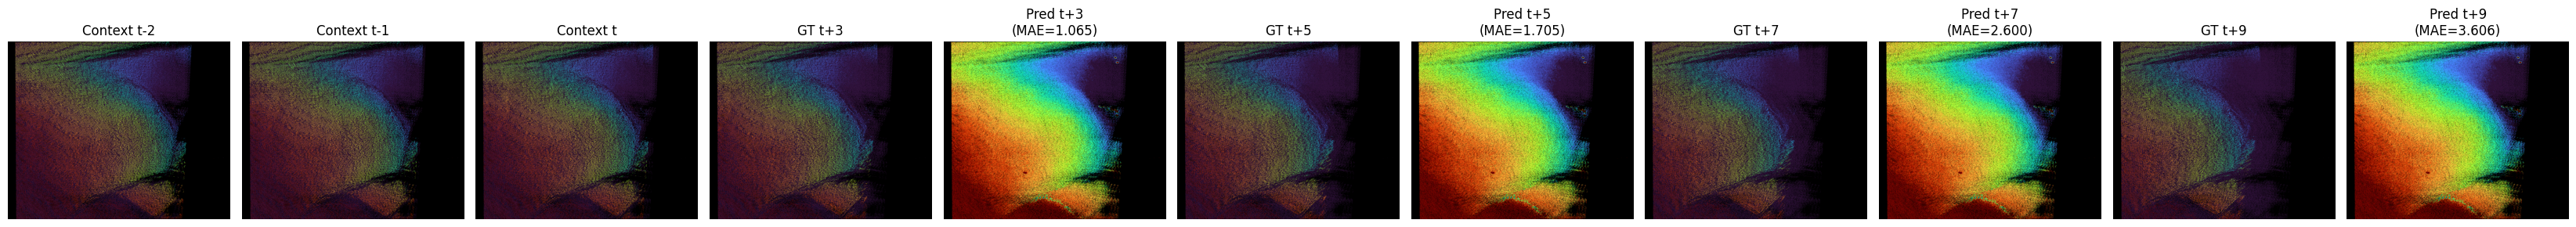

In [ ]:
ctx_colors = [disp_to_raft_color_fixed_range(f, vmin, vmax, valid_union)
              for f in ctx_np]

gt_colors = {
    h: disp_to_raft_color_fixed_range(gt_dict[h], vmin, vmax, valid_union)
    for h in HORIZONS
}
pred_colors = {
    h: disp_to_raft_color_fixed_range(pred_dict[h], vmin, vmax, valid_union)
    for h in HORIZONS
}

cols = 3 + 2 * len(HORIZONS)
plt.figure(figsize=(3*cols, 3))

# contexts
titles_ctx = ["Context t-2", "Context t-1", "Context t"]
for i in range(3):
    ax = plt.subplot(1, cols, i+1)
    ax.imshow(ctx_colors[i])
    ax.set_title(titles_ctx[i])
    ax.axis("off")

# horizons
for j, h in enumerate(HORIZONS):
    col_gt = 3 + 2*j + 1
    col_pred = 3 + 2*j + 2

    ax_gt = plt.subplot(1, cols, col_gt)
    ax_gt.imshow(gt_colors[h])
    ax_gt.set_title(f"GT t+{h}")
    ax_gt.axis("off")

    ax_pred = plt.subplot(1, cols, col_pred)
    ax_pred.imshow(pred_colors[h])
    ax_pred.set_title(f"Pred t+{h}\n(MAE={mae_dict[h]:.3f})")
    ax_pred.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# quantifying differences between horizons
ref_h = 3
for h in HORIZONS:
    diff = np.abs(pred_dict[h] - pred_dict[ref_h])
    print(f"h={h}: mean |pred_h - pred_3| = {diff.mean():.4f}, max = {diff.max():.4f}")


h=3: mean |pred_h - pred_3| = 0.0000, max = 0.0000
h=5: mean |pred_h - pred_3| = 0.0422, max = 0.2335
h=7: mean |pred_h - pred_3| = 0.0844, max = 0.4670
h=9: mean |pred_h - pred_3| = 0.1263, max = 0.7005


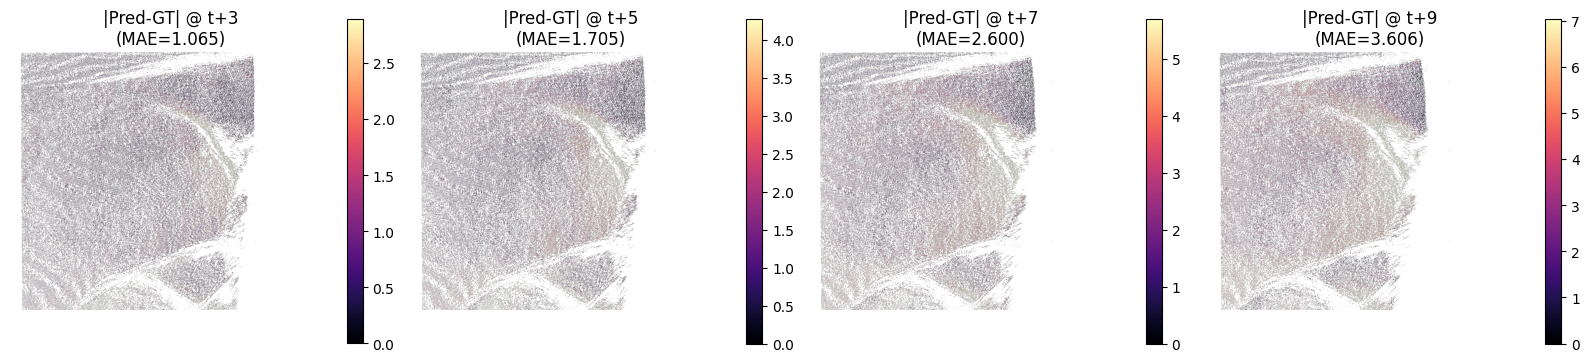

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(4*len(HORIZONS), 4))

for j, h in enumerate(HORIZONS):
    tgt_np  = gt_dict[h]
    pred_np = pred_dict[h]
    valid_mask = tgt_np > 0

    err = np.abs(pred_np - tgt_np)
    err[~valid_mask] = np.nan

    vmax_err = np.nanpercentile(err, 95)

    ax = plt.subplot(1, len(HORIZONS), j+1)
    im = ax.imshow(err, cmap="magma", vmin=0, vmax=vmax_err)
    ax.set_title(f"|Pred-GT| @ t+{h}\n(MAE={mae_dict[h]:.3f})")
    ax.axis("off")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [ ]:
tgt_np = gt_dict[5]
pred_np = pred_dict[5]
valid = tgt_np > 0

print("GT:   min", tgt_np[valid].min(), "max", tgt_np[valid].max(), "mean", tgt_np[valid].mean())
print("Pred: min", pred_np[valid].min(), "max", pred_np[valid].max(), "mean", pred_np[valid].mean())


GT:   min 1.0195312 max 251.3711 mean 39.699966
Pred: min 22.637285 max 124.22425 mean 40.96431


We freeze the UNet t+5 forecaster and train a small horizon-conditioned head to support multiple display delays (t+3, t+5, t+7, t+9).
Across the SCARED validation set the MAE increases smoothly with horizon, and per-pixel error maps show similar spatial structure but larger magnitude for longer delays.
Although the raw disparity visualizations look similar across horizons (because the underlying tissue motion is smooth), difference maps and |Pred−GT| heatmaps confirm that the head makes meaningful, horizon-dependent corrections on top of the frozen UNet.